In [146]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

import time
import argparse
import json

from wavenet_model import *
from wavenet_modules import *
from audio_data import WavenetDataset, AudioDataset
from vae import VAE, WaveNetEncoder, WaveNetDecoder, OneHotConvolutionalEncoder, BetterWaveNetDecoder, gumbel_softmax
from vae_gaussian import GaussianVAE, GaussianWaveNetEncoder, GaussianWaveNetDecoder
from wavenet_utils import one_hot

import torch
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchaudio
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import mpld3
from torch.distributions.categorical import Categorical

In [7]:
mpld3.disable_notebook()

In [10]:
snapshot_name = "51"
with open(f"configs/{snapshot_name}.json") as f:
    data = f.read()
config = json.loads(data)
encoder_wavenet_args = config["encoder_wavenet_args"]
decoder_wavenet_args = config["decoder_wavenet_args"]
train_args = config["train_args"]
batch_size = train_args["batch_size"]
epochs = train_args["epochs"]
continue_training_at_step = train_args["continue_training_at_step"]
snapshot_path = f"snapshots/{snapshot_name}"
snapshot_interval = train_args["snapshot_interval"]
weight_decay  = train_args["weight_decay"]
lr = train_args["lr"]
device_name = config["device"]
gpu_index = config["gpu_index"]
dataset_path = config["dataset_path"]
load_path = config["load_path"]
n_z_samples = config["n_z_samples"]
type = config.get("type", "categorical")
flip_decoder = config.get("flip_decoder", True)
data_length = config.get("data_length", None)

if type in {"categorical", "multimodal", "convolutional", "betterwavenet", "mfcc_betterwavenet"}:
    ar_factor = train_args.get("ar_factor", None)
    hard_gumbel_softmax = train_args.get("hard_gumbel_softmax", False)
    gumbel_softmax_temperature = train_args["gumbel_softmax_temperature"]
    posterior_entropy_penalty_coeff = train_args["posterior_entropy_penalty_coeff"]
    if not hard_gumbel_softmax:
        temp_min = train_args["temp_min"]
        anneal_rate = train_args["anneal_rate"]

if type == "categorical":
    model = VAE(
        WaveNetEncoder(encoder_wavenet_args),
        WaveNetDecoder(decoder_wavenet_args, flip_decoder),
        hard_gumbel_softmax=hard_gumbel_softmax,
    )
elif type == "multimodal":
    model = VAE(
        MultimodalWaveNetEncoder(encoder_wavenet_args),
        WaveNetDecoder(decoder_wavenet_args, flip_decoder),
        hard_gumbel_softmax=hard_gumbel_softmax,
    ) 
elif type == "convolutional":
    model = VAE(
        OneHotConvolutionalEncoder(encoder_wavenet_args),
        WaveNetDecoder(decoder_wavenet_args, flip_decoder),
        hard_gumbel_softmax=hard_gumbel_softmax,
    ) 
elif type == "betterwavenet":
    model = VAE(
        OneHotConvolutionalEncoder(encoder_wavenet_args),
        BetterWaveNetDecoder(decoder_wavenet_args),
        hard_gumbel_softmax=hard_gumbel_softmax,
    ) 
elif type == "mfcc_betterwavenet":
    model = VAE(
        MFCCConvolutionalEncoder(**encoder_wavenet_args),
        BetterWaveNetDecoder(decoder_wavenet_args),
        hard_gumbel_softmax=hard_gumbel_softmax,
    ) 

ConvolutionalEncoder.__init__ called with num_hiddens = 768
dilation 1
dilation 1


In [11]:
checkpoint_dict = torch.load(f"snapshots/{snapshot_name}/{snapshot_name}_124000", map_location='cpu')
model = nn.DataParallel(model)
model.load_state_dict(checkpoint_dict['model'])
model = model.module

In [12]:
if data_length is None:
    receptive_field_closest_power_of_3 = int(3**math.ceil(math.log(model.decoder.wavenet.receptive_field, 3)))
    data_length = receptive_field_closest_power_of_3 * 3
dataset = AudioDataset("wav_audio/small_wav_tensor.pt", data_length)        

len(dataset)

508

# Visualize x and VAE results for Categorical latents

In [140]:
x = dataset[109:110].long()

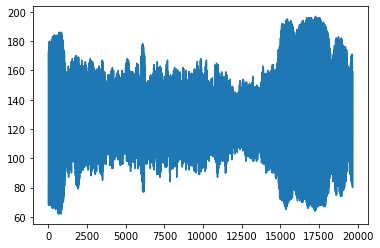

In [141]:
plt.plot(x[0])

In [26]:
p_x, q_z = model(x, temperature = 1.)
p_x.shape, q_z.shape

(torch.Size([2, 256, 19683]), torch.Size([2, 256, 243]))

## Plot the latents

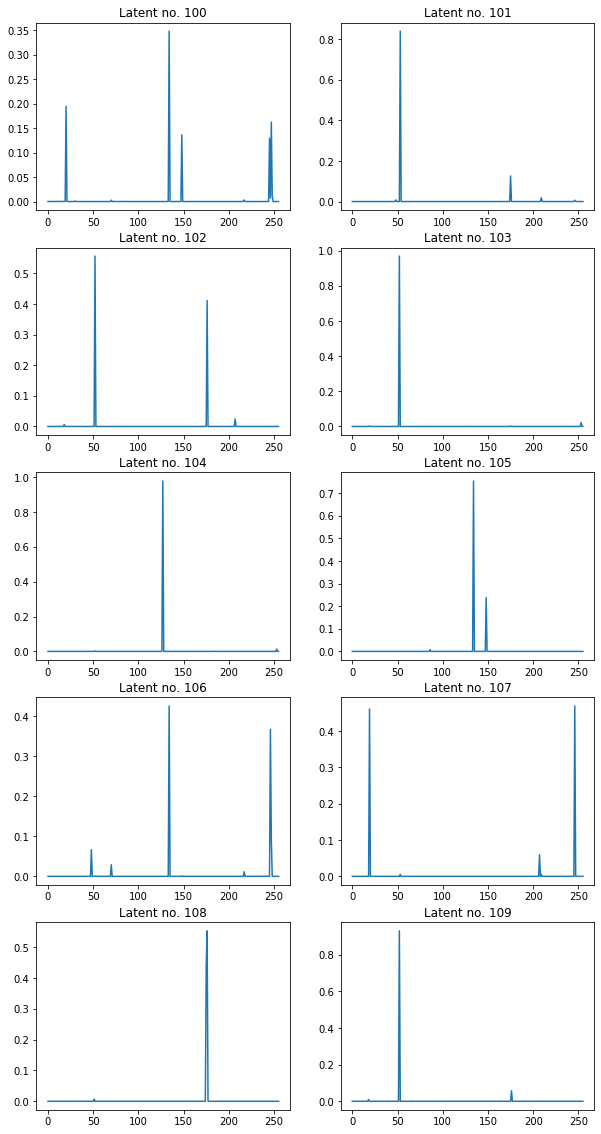

In [27]:
q_z_probs = F.softmax(q_z, dim=1)
n_plots = 10
fig, axes = plt.subplots(nrows=(n_plots+1)//2, ncols=2, figsize=(10, 2*n_plots))
for ax, col_idx in zip([ax for axs in axes for ax in axs], range(n_plots)):
    latent_idx = 100+col_idx
    ax.plot(q_z_probs[0,:,latent_idx].detach().numpy())
    ax.set_title(f"Latent no. {latent_idx}")

## Fetch the local conditioning upsampling weights and compare them with other weights

In [32]:
upsample_conv = model.decoder.wavenet.upsample_conv
upsample_conv

ModuleList(
  (0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(1, 3), padding=(1, 0))
  (1): ReLU(inplace=True)
  (2): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(1, 3), padding=(1, 0))
  (3): ReLU(inplace=True)
  (4): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(1, 3), padding=(1, 0))
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(1, 3), padding=(1, 0))
  (7): ReLU(inplace=True)
)

In [41]:
for i in range(0, len(upsample_conv), 2):
    print(upsample_conv[i].weight_g)

Parameter containing:
tensor([[[[1.2053]]]], requires_grad=True)
Parameter containing:
tensor([[[[1.2077]]]], requires_grad=True)
Parameter containing:
tensor([[[[1.2062]]]], requires_grad=True)
Parameter containing:
tensor([[[[1.2023]]]], requires_grad=True)


In [42]:
for i in range(0, len(upsample_conv), 2):
    print(upsample_conv[i].weight_v)

Parameter containing:
tensor([[[[ 0.6213,  0.6089,  0.1180],
          [ 0.2458,  0.1654, -0.0015],
          [ 0.0449,  0.4334,  0.2947]]]], requires_grad=True)
Parameter containing:
tensor([[[[0.5651, 0.6299, 0.5022],
          [0.0557, 0.0381, 0.0186],
          [0.1248, 0.2081, 0.2269]]]], requires_grad=True)
Parameter containing:
tensor([[[[0.5595, 0.6149, 0.5502],
          [0.0301, 0.0221, 0.0246],
          [0.1646, 0.1914, 0.1820]]]], requires_grad=True)
Parameter containing:
tensor([[[[0.6251, 0.6210, 0.6199],
          [0.0184, 0.0198, 0.0191],
          [0.1353, 0.1384, 0.1395]]]], requires_grad=True)


### Standard deviation of convolution weights for x

In [62]:
model.decoder.wavenet.conv_layers[2].conv.weight.std()

tensor(0.0264, grad_fn=<StdBackward0>)

### Standard deviation of convolution weights for c

In [61]:
model.decoder.wavenet.conv_layers[2].conv1x1c.weight.std()

tensor(0.0613, grad_fn=<StdBackward0>)

## Calculate the loss for the correct latents and for arbitrary latents

In [142]:
q_z = model.encode(x)
z = gumbel_softmax(q_z, 1.0, model.hard_gumbel_softmax)
p_x = model.decode(z, x)
loss = model.loss(p_x, x, q_z, free_bits_per_dimension=1.0)

max(free_kl_divergence, kl_divergence) tensor(13643.2158)


In [143]:
loss

{'loss': tensor(55330.8477, grad_fn=<AddBackward0>),
 'cross_entropy': tensor(41687.6328, grad_fn=<DivBackward0>),
 'kl_divergence': tensor(1038.5109, grad_fn=<DivBackward0>),
 'posterior_entropy_penalty': tensor(308.9673, grad_fn=<DivBackward0>)}

In [144]:
bits_per_dimension = ((loss['kl_divergence']+loss['cross_entropy'])/math.log(2)) / x.size(-1)
bits_per_dimension

tensor(3.1317, grad_fn=<DivBackward0>)

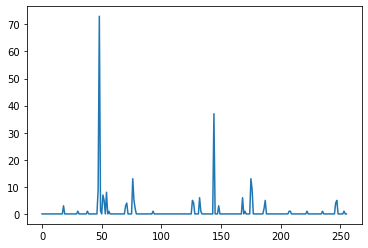

In [148]:
plt.plot(z.sum(dim=-1)[0].detach().numpy())

In [149]:
rand_q_z = torch.rand(q_z.size())
rand_z = gumbel_softmax(rand_q_z, 1.0, model.hard_gumbel_softmax)
rand_p_x = model.decode(rand_z, x)
rand_loss = model.loss(rand_p_x, x, rand_q_z, free_bits_per_dimension=1.0)

max(free_kl_divergence, kl_divergence) tensor(13643.2158)


In [150]:
rand_loss

{'loss': tensor(56671.6211, grad_fn=<AddBackward0>),
 'cross_entropy': tensor(43028.4062, grad_fn=<DivBackward0>),
 'kl_divergence': tensor(9.8570),
 'posterior_entropy_penalty': tensor(1337.6212)}

In [151]:
bits_per_dimension = ((rand_loss['kl_divergence']+rand_loss['cross_entropy'])/math.log(2)) / x.size(-1)
bits_per_dimension

tensor(3.1546, grad_fn=<DivBackward0>)

## Plot the output probabilities

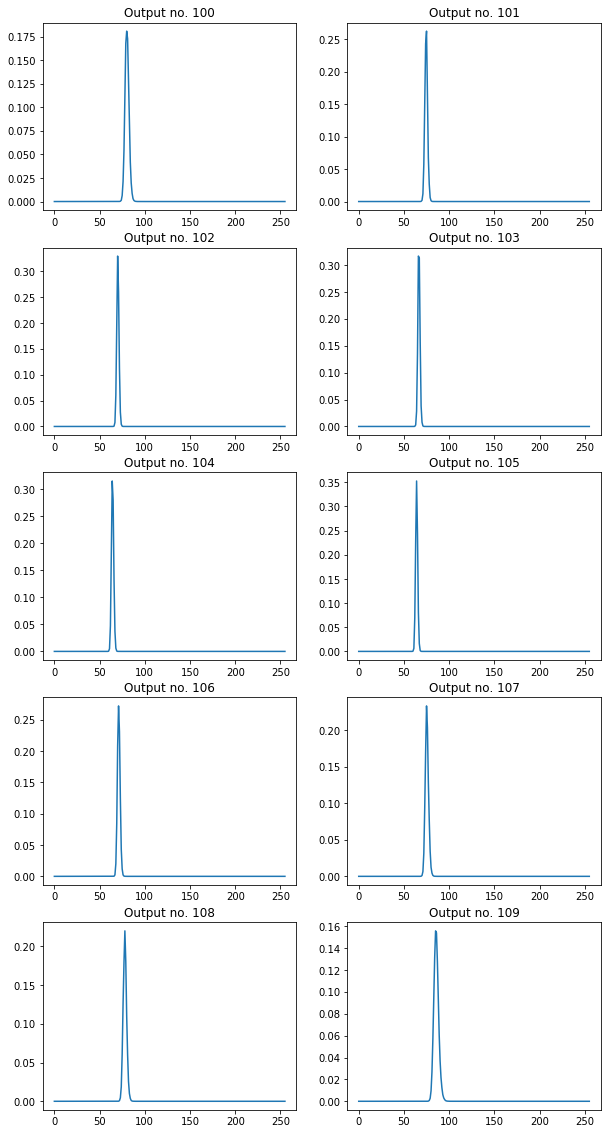

In [18]:
p_x_probs = F.softmax(p_x, dim=1)
n_plots = 10
fig, axes = plt.subplots(nrows=(n_plots+1)//2, ncols=2, figsize=(10, 2*n_plots))
for ax, col_idx in zip([ax for axs in axes for ax in axs], range(n_plots)):
    output_idx = 100+col_idx
    ax.plot(p_x_probs[0,:,output_idx].detach().numpy())
    ax.set_title(f"Output no. {output_idx}")

## Plot the average of the probability distributions of all neighboring latent variables

In [12]:
zs = q_z_probs[0, :, 0:100]
zs_shifted = q_z_probs[0, :, 1:101]
joint_neighbors_zs = zs.unsqueeze(0) * zs_shifted.unsqueeze(1)
joint_neighbors_zs.size()

torch.Size([256, 256, 100])

In [13]:
joint_neighbors_zs_avg = joint_neighbors_zs.mean(dim=2)

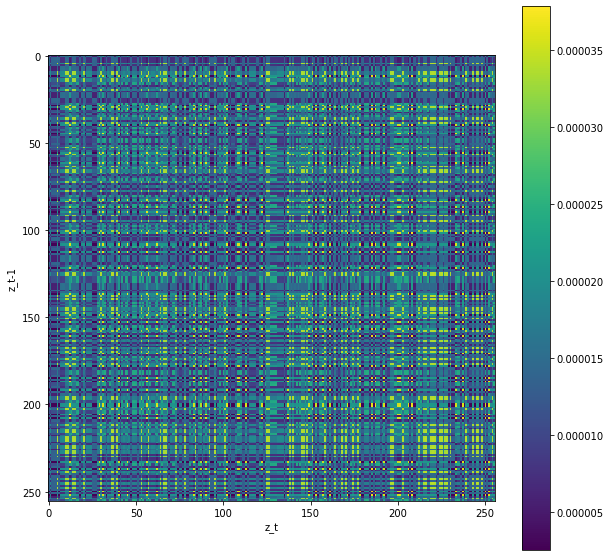

In [14]:
fig, axes = plt.subplots(figsize=(10, 10))
axes.set_xlabel("z_t")
axes.set_ylabel("z_t-1")
mappable = axes.imshow(joint_neighbors_zs_avg.detach().numpy())
fig.colorbar(mappable, ax=axes)

# Visualize x and VAE results for Gaussian latents

In [61]:
x = dataset[700].long().unsqueeze(0)

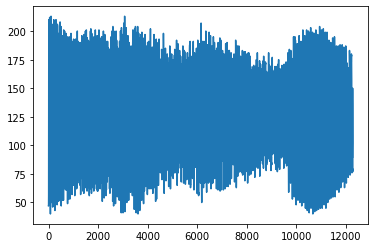

In [62]:
plt.plot(x[0])

In [163]:
p_x, mu, logvar = model(x)

In [164]:
logvar.size(), logvar.mean(), logvar.min(), logvar.max()

(torch.Size([1, 256, 32512]),
 tensor(-0.0103, grad_fn=<MeanBackward0>),
 tensor(-4.8627, grad_fn=<MinBackward1>),
 tensor(0.0645, grad_fn=<MaxBackward1>))

In [165]:
mu.size(), mu.mean(), mu.min(), mu.max(), mu.var()

(torch.Size([1, 256, 32512]),
 tensor(0.0008, grad_fn=<MeanBackward0>),
 tensor(-2.7132, grad_fn=<MinBackward1>),
 tensor(2.6551, grad_fn=<MaxBackward1>),
 tensor(0.0041, grad_fn=<VarBackward0>))

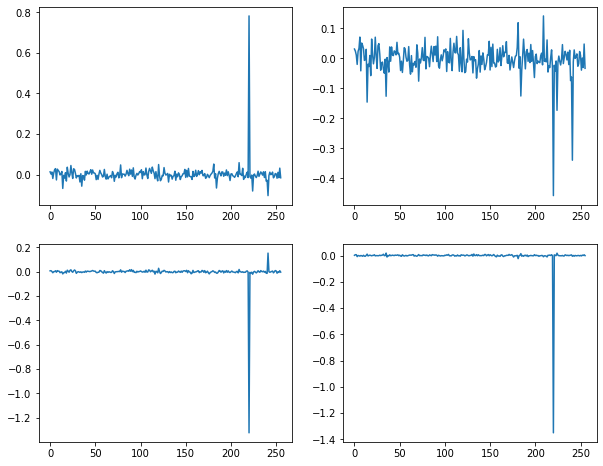

In [166]:
n_plots = 4
fig, axes = plt.subplots(nrows=(n_plots+1)//2, ncols=2, figsize=(10, 2*n_plots))
for ax, col_idx in zip([ax for axs in axes for ax in axs], range(n_plots)):
    ax.plot(mu[0,:,100+col_idx].detach().numpy())

In [167]:
loss, cross_entropy, kl_divergence = model.loss(p_x, x, mu, logvar)

In [168]:
loss, cross_entropy, kl_divergence

(tensor(131396.0625, grad_fn=<AddBackward0>),
 tensor(89249.7266, grad_fn=<DivBackward0>),
 tensor(42146.3438, grad_fn=<DivBackward0>))

In [169]:
bits_per_dimension = (loss/math.log(2)) / x.size(-1)
bits_per_dimension

tensor(5.8306, grad_fn=<DivBackward0>)

# Store x and reconstructed x

In [170]:
x_encoded = x.squeeze()
x_decoded = torchaudio.transforms.MuLawDecoding(quantization_channels=256)(x_encoded)

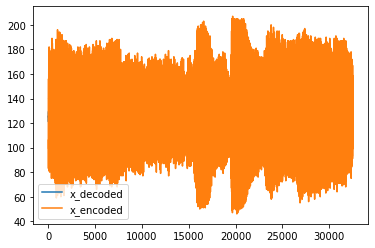

In [171]:
plt.plot(range(len(x_decoded)), x_decoded*256 + 127, range(len(x_encoded)), x_encoded)
plt.legend(['x_decoded', 'x_encoded'])


In [175]:
torchaudio.save('model_audio_samples/x.wav', x_decoded.unsqueeze(0), channels_first=True, sample_rate=16000)

In [172]:
m = torch.distributions.categorical.Categorical(logits=p_x.permute(0, 2, 1))
x_reconstructed = m.sample().float().squeeze()

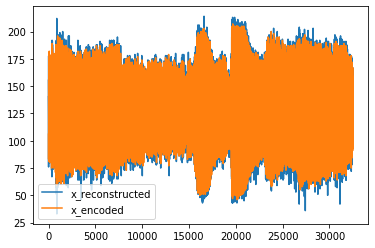

In [174]:
plt.plot(range(len(x_reconstructed)), x_reconstructed, range(len(x_reconstructed)), x_encoded[:len(x_reconstructed)])
plt.legend(['x_reconstructed', 'x_encoded'])

In [176]:
x_reconstructed_decoded = torchaudio.transforms.MuLawDecoding(quantization_channels=256)(x_reconstructed)
torchaudio.save('model_audio_samples/x_reconstructed.wav', x_reconstructed_decoded.unsqueeze(0), channels_first=True, sample_rate=16000)

# Generate x from sampled z

## 1. Sample z ~ p(z)

In [181]:
z = torch.randn(1, 256, len(dataset[0]))

## 2. Decode z to get p(x|z)

In [186]:
p_x = model.decode(z)

## 3. Sample x from p(x|z)

In [187]:
m = torch.distributions.categorical.Categorical(logits=p_x.permute(0, 2, 1))
x = m.sample().float().squeeze()

## 4. Decode the mu-encoded x

In [188]:
x_decoded = torchaudio.transforms.MuLawDecoding(quantization_channels=256)(x)

## 5. Generate audio file from x_decoded

In [191]:
torchaudio.save('model_audio_samples/x_generated.wav', x_decoded.unsqueeze(0), channels_first=True, sample_rate=16000)